# Traffic Analysis: Data Cleaning andFeature Engineering

In [125]:
# import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [168]:
# load data
data = pd.read_csv('C:/Users/xiaoj/Downloads/Average_Daily_Traffic_Counts.csv')
data.head()

,ID,Traffic Volume Count Location Address,Street,Date of Count,Total Passing Vehicle Volume,Vehicle Volume By Each Direction of Traffic,Latitude,Longitude,Location
0,2,1708 West,71st Street,3/9/2006,14600,East Bound: 6900 / West Bound: 7700,41.764877,-87.666635,"(41.764877, -87.666635)"
1,3,1275 West,71st Street,2/28/2006,16500,East Bound: 7800 / West Bound: 8700,41.765008,-87.657067,"(41.765008, -87.657067)"
2,5,920 West,71st Street,2/28/2006,18200,East Bound: 8800 / West Bound: 9400,41.765153,-87.647751,"(41.765153, -87.647751)"
3,6,758 West,71st Street,2/28/2006,21600,East Bound: 10400 / West Bound: 11200,41.765204,-87.644371,"(41.765204, -87.644371)"
4,7,240 East,71st St,2/28/2006,18300,East Bound: 9000 / West Bound: 9300,41.765644,-87.618476,"(41.765644, -87.618476)"


In [169]:
# check the null values and total data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1279 entries, 0 to 1278
Data columns (total 9 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   ID                                           1279 non-null   int64  
 1   Traffic Volume Count Location  Address       1279 non-null   object 
 2   Street                                       1279 non-null   object 
 3   Date of Count                                1279 non-null   object 
 4   Total Passing Vehicle Volume                 1279 non-null   int64  
 5   Vehicle Volume By Each Direction of Traffic  1279 non-null   object 
 6   Latitude                                     1279 non-null   float64
 7   Longitude                                    1279 non-null   float64
 8   Location                                     1279 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 90.1+ KB


In [170]:
# check all the columns
data.columns

Index(['ID ', 'Traffic Volume Count Location  Address', 'Street',
       'Date of Count', 'Total Passing Vehicle Volume',
       'Vehicle Volume By Each Direction of Traffic', 'Latitude', 'Longitude',
       'Location'],
      dtype='object')

In [171]:
# rename the column names
data = data.rename(columns = {"ID ":"ID", 'Traffic Volume Count Location  Address':"Address", 'Date of Count':'Date', 'Total Passing Vehicle Volume':'Total', 'Vehicle Volume By Each Direction of Traffic':'Direction'})

In [172]:
# check the renaming result
data.head()

,ID,Address,Street,Date,Total,Direction,Latitude,Longitude,Location
0,2,1708 West,71st Street,3/9/2006,14600,East Bound: 6900 / West Bound: 7700,41.764877,-87.666635,"(41.764877, -87.666635)"
1,3,1275 West,71st Street,2/28/2006,16500,East Bound: 7800 / West Bound: 8700,41.765008,-87.657067,"(41.765008, -87.657067)"
2,5,920 West,71st Street,2/28/2006,18200,East Bound: 8800 / West Bound: 9400,41.765153,-87.647751,"(41.765153, -87.647751)"
3,6,758 West,71st Street,2/28/2006,21600,East Bound: 10400 / West Bound: 11200,41.765204,-87.644371,"(41.765204, -87.644371)"
4,7,240 East,71st St,2/28/2006,18300,East Bound: 9000 / West Bound: 9300,41.765644,-87.618476,"(41.765644, -87.618476)"


Checking the unique values can not only give us information about how many unique values of the feature has but also tell us which features can be used to count. From the following result, it can be found that the ID is unique feature for every data, which means it can be used to count when needed. 

In [173]:
# check the unique values of every feature
for i in data.columns:
    print("The nunique numbers of "+ i+ " is: " + str(data[i].nunique()))

The nunique numbers of ID is: 1279
The nunique numbers of Address is: 1203
The nunique numbers of Street is: 251
The nunique numbers of Date is: 95
The nunique numbers of Total is: 398
The nunique numbers of Direction is: 1223
The nunique numbers of Latitude is: 1272
The nunique numbers of Longitude is: 1275
The nunique numbers of Location is: 1276


In [174]:
# use the latitute and longitude to get the city information
import geocoder
def geo_rev(x):
    g=geocoder.osm([x['Latitude'], x['Longitude']],method = 'reverse').json
    if g:
        return g.get('city')
        
    else:
        return 'none'
data['city']=data[['Latitude','Longitude']].apply(geo_rev, axis=1)

In [175]:
# Check how many cities included
data['city'].value_counts()

Chicago    1266
Name: city, dtype: int64

In [176]:
data.head(3)

,ID,Address,Street,Date,Total,Direction,Latitude,Longitude,Location,city
0,2,1708 West,71st Street,3/9/2006,14600,East Bound: 6900 / West Bound: 7700,41.764877,-87.666635,"(41.764877, -87.666635)",Chicago
1,3,1275 West,71st Street,2/28/2006,16500,East Bound: 7800 / West Bound: 8700,41.765008,-87.657067,"(41.765008, -87.657067)",Chicago
2,5,920 West,71st Street,2/28/2006,18200,East Bound: 8800 / West Bound: 9400,41.765153,-87.647751,"(41.765153, -87.647751)",Chicago


In [210]:
# check the address of those with no city
data_no_city = data[data['city']!='Chicago']
for i in data_no_city['Location']:
    lat = i[1:-1].split(",")[0]
    long = i[1:-1].split(",")[1]
    print(i + ": " + geocoder.osm([lat,long], method = 'reverse').json.get('address'))

(41.692257, -87.720366): Breakfast Club, South Pulaski Road, Mount Greenwood, Oak Lawn, Lake Township, Cook County, Illinois, 60453, United States
(41.68508, -87.700584): Cash America Pawn, 11445, South Kedzie Avenue, Mount Greenwood, Merrionette Park, Worth Township, Cook County, Illinois, 60803, United States
(41.896495, -87.775191): Austin & Iowa SB, North Austin Boulevard, Ridgeland, Oak Park, Cook County, Illinois, 60302, United States
(41.908868, -87.804756): North & Harlem Plaza, West North Avenue, Oak Park, Cook County, Illinois, 60302, United States
(41.677257, -87.680696): 119th Street & Western, West 119th Street, Morgan Park, Blue Island, Calumet Township, Cook County, Illinois, 60406, United States
(41.735341, -87.693452): 2847, West 87th Street, Evergreen Park, Worth Township, Cook County, Illinois, 60805, United States
(41.987853, -87.846528): North East River Road, O'Hare, Park Ridge, Leyden Township, Cook County, Illinois, 60656, United States
(41.957636, -87.799463): 

It can be found from above information that those without city information are either township or park. Since there are only 13 data without city information, and the majority (98.98% = 1266 / 1279) of data belongs to Chicago city. I would like to focus our analysis on the city of Chicago.

In [211]:
# get the data in Chicago and update the data
data_chicago = data[data['city']=='Chicago'].reset_index(drop = True)

In [212]:
# drop some irrelevant columns
data_chicago = data_chicago.drop(['Location','city'],1)
data_chicago.head()

,ID,Address,Street,Date,Total,Direction,Latitude,Longitude
0,2,1708 West,71st Street,3/9/2006,14600,East Bound: 6900 / West Bound: 7700,41.764877,-87.666635
1,3,1275 West,71st Street,2/28/2006,16500,East Bound: 7800 / West Bound: 8700,41.765008,-87.657067
2,5,920 West,71st Street,2/28/2006,18200,East Bound: 8800 / West Bound: 9400,41.765153,-87.647751
3,6,758 West,71st Street,2/28/2006,21600,East Bound: 10400 / West Bound: 11200,41.765204,-87.644371
4,7,240 East,71st St,2/28/2006,18300,East Bound: 9000 / West Bound: 9300,41.765644,-87.618476


In [213]:
# change the date type from object to datetime
data_chicago['Date'] = pd.to_datetime(data_chicago['Date'])

# build new feature of year, month and day 
data_chicago['year'] = data_chicago['Date'].dt.year
data_chicago['month'] = data_chicago['Date'].dt.month
data_chicago['day'] = data_chicago['Date'].dt.day_name()

# check and review the data 
data_chicago.head()

,ID,Address,Street,Date,Total,Direction,Latitude,Longitude,year,month,day
0,2,1708 West,71st Street,2006-03-09,14600,East Bound: 6900 / West Bound: 7700,41.764877,-87.666635,2006,3,Thursday
1,3,1275 West,71st Street,2006-02-28,16500,East Bound: 7800 / West Bound: 8700,41.765008,-87.657067,2006,2,Tuesday
2,5,920 West,71st Street,2006-02-28,18200,East Bound: 8800 / West Bound: 9400,41.765153,-87.647751,2006,2,Tuesday
3,6,758 West,71st Street,2006-02-28,21600,East Bound: 10400 / West Bound: 11200,41.765204,-87.644371,2006,2,Tuesday
4,7,240 East,71st St,2006-02-28,18300,East Bound: 9000 / West Bound: 9300,41.765644,-87.618476,2006,2,Tuesday


In [214]:
# Split the 'Direction' features into four new features: two direction + corresponding volumes
data_chicago['0_direction'] = data_chicago['Direction'].str.split('/').str[0].str.split(':').str[0].str[:-6].str.strip()
data_chicago['0_volume'] = data_chicago['Direction'].str.split('/').str[0].str.split(':').str[1].astype(np.int64)
data_chicago['1_direction'] = data_chicago['Direction'].str.split('/').str[1].str.split(':').str[0].str[:-6].str.strip()
data_chicago['1_volume'] = data_chicago['Direction'].str.split('/ ').str[1].str.split(':').str[1].replace(np.nan, 0).astype(np.int64)
data_chicago = data_chicago.drop('Direction', 1)
data_chicago.head()

,ID,Address,Street,Date,Total,Latitude,Longitude,year,month,day,0_direction,0_volume,1_direction,1_volume
0,2,1708 West,71st Street,2006-03-09,14600,41.764877,-87.666635,2006,3,Thursday,East,6900,West,7700
1,3,1275 West,71st Street,2006-02-28,16500,41.765008,-87.657067,2006,2,Tuesday,East,7800,West,8700
2,5,920 West,71st Street,2006-02-28,18200,41.765153,-87.647751,2006,2,Tuesday,East,8800,West,9400
3,6,758 West,71st Street,2006-02-28,21600,41.765204,-87.644371,2006,2,Tuesday,East,10400,West,11200
4,7,240 East,71st St,2006-02-28,18300,41.765644,-87.618476,2006,2,Tuesday,East,9000,West,9300


In [215]:
# check what kinds of values included in '0_direction'
data_chicago['0_direction'].value_counts()

North    640
East     557
South     39
West      30
Name: 0_direction, dtype: int64

In [216]:
# check what kinds of values included in '1_direction'
data_chicago['1_direction'].value_counts()

South           613
West            529
                 54
Oneway South     39
Oneway West      30
Oneway North      1
Name: 1_direction, dtype: int64

It is know that there should be at most four directions. However, there are more special situations in feature['1_direction']. I will unify these values. For example, since the "0_direction" and "1_direction" are splitted from the previous feature "direction", they should always be the opposite. When the total volumes is same with the volumes in ["0_direction"], it means that volumes of the opposite direction is 0 and vice verse.

In [217]:
# unify the direction in "1_direction"
dic={'South':"North","North":"South","East":"West","West":"East"}

for i in range(1266):   
    if data_chicago.loc[i,'Total']==data_chicago.loc[i,"0_volume"]:
        data_chicago.loc[i,'1_volume'] = 0
    data_chicago.loc[i,'1_direction'] = dic[data_chicago.loc[i,"0_direction"]]
data_chicago['1_direction'].value_counts()

South    640
West     557
North     39
East      30
Name: 1_direction, dtype: int64

In [218]:
# Check the abbreviation of the name of "Street" 
data_chicago['Street'].str.split(' ').str[-1].value_counts()

Ave           597
St            407
Rd             85
Street         50
Dr             50
Blvd           43
Broadway        7
Pkwy            4
ST              3
Ct              2
Hwy             2
L               2
O               2
Plaisance       2
83rdStreet      1
II              1
Plaissance      1
CT              1
rd)             1
pass)           1
Pl              1
(lower)         1
RD              1
PL              1
Name: Street, dtype: int64

Based on above information, it is easily to found that there are some duplicate abbreviations and some name are not abbreviated as expected. All can be summarized as following:
- Street: St;
- ST: St;
- RD: Rd;
- CT: Ct;
- PL: Pl;
- Plaissance: Plaisance;
- Western Ave (over pass): Western Ave;
- Wacker Dr (lower):Wacker Dr;
- Western Ave (frontage rd):vWestern Ave
- 83rdStreet: 83rd St

In [219]:
# modify the abbreviations of streets
data_chicago['Street']=data_chicago['Street'].replace({"Western Ave (over pass)":"Western Ave","Wacker Dr (lower)":"Wacker Dr", "Western Ave (frontage rd)":"Western Ave", "Plaissance":"Plaisance"},regex=False)
data_chicago['Street']=data_chicago['Street'].replace({'Street':'St', "ST":"St","RD":"Rd","CT":"Ct","PL":"Pl"},regex = True)
data_chicago['Street']=data_chicago['Street'].apply(lambda s: s.replace("83rdStreet","83rd  St"))
data_chicago['Street']=data_chicago['Street'].apply(lambda s: s.replace("Plaissance","Plaisance"))

data_chicago['Street'].str.split(' ').str[-1].value_counts()

Ave          599
St           460
Rd            86
Dr            51
Blvd          43
Broadway       7
Pkwy           4
Ct             3
Plaisance      3
Hwy            2
L              2
O              2
Pl             2
83rdSt         1
II             1
Name: Street, dtype: int64

In [220]:
data_chicago[data_chicago['Street'].str.split(' ').str[-1]=='L']

,ID,Address,Street,Date,Total,Latitude,Longitude,year,month,day,0_direction,0_volume,1_direction,1_volume
134,156,9621 South,Avenue L,2006-03-21,5000,41.720702,-87.536499,2006,3,Tuesday,North,3200,South,1800
135,157,10129 South,Avenue L,2006-03-21,4200,41.711118,-87.536485,2006,3,Tuesday,North,2100,South,2100


In [151]:
data_chicago[data_chicago['Street'].str.split(' ').str[-1]=='O']

,ID,Address,Street,Date,Total,Latitude,Longitude,year,month,day,0_direction,0_volume,1_direction,1_volume
696,751,11233 South,Avenue O,2006-10-18,16000,41.690863,-87.540104,2006,10,Wednesday,North,8100,South,7900
1191,1299,10928 South,Avenue O,2006-10-18,12400,41.696434,-87.540090,2006,10,Wednesday,North,7000,South,5400


In [152]:
# check the detailed information of "II"
data_chicago[data_chicago['Street'].str.split(' ').str[-1]=='II']

,ID,Address,Street,Date,Total,Latitude,Longitude,year,month,day,0_direction,0_volume,1_direction,1_volume
343,375,2701 West,Pope John Paul II,2006-05-09,7000,41.815579,-87.692019,2006,5,Tuesday,West,7000,East,0


In [153]:
# Check if the abbrivative has been changed
data_chicago['Street'].str.split(' ').str[-1].value_counts()

Ave          599
St           460
Rd            86
Dr            51
Blvd          43
Broadway       7
Pkwy           4
Ct             3
Plaisance      3
Hwy            2
L              2
O              2
Pl             2
83rdSt         1
II             1
Name: Street, dtype: int64

In [221]:
# save the datafile 
data_chicago.to_csv('data_chicago.csv')

## Q1: What is the busiest street?

In [277]:
# check the busiest street
data_chicago.groupby('Street')['Total'].sum().sort_values(ascending = False).head(1)

Street
Western Ave    1154200
Name: Total, dtype: int64

Based on all the data we have, it is easily to find that the busiest street is "Western Ave". However, since this is sample counts that will be taken to used to estimate the whole traffic in future, I have to check the counts distribution and if the sample is selected randomly as following.

In [234]:
# Street Vs. count times
data_chicago['Street'].value_counts()

Western Ave          34
Damen Ave            33
Ashland Ave          31
Pulaski Rd           26
Halsted St           26
                     ..
Yates Blvd            1
South Chicago Ave     1
95Th St               1
57th St               1
106th St              1
Name: Street, Length: 231, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text major ticklabel objects>)

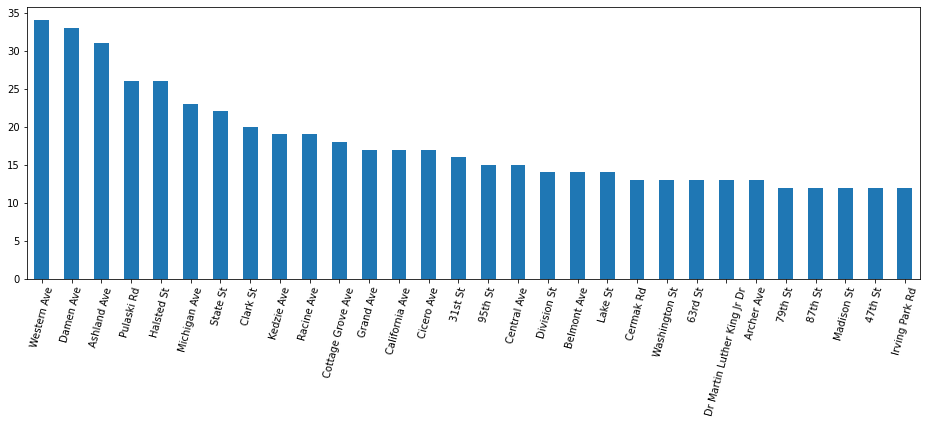

In [271]:
# Visualization of Street Vs. count times
data_chicago['Street'].value_counts().sort_values(ascending=False).head(30).plot(kind='bar',figsize = (16,5))
plt.xticks(rotation=75)

From the above information, it is easily to find that streets are not countted randomly,for example, some streets are countted too many times compared with others, while some streets are only counted once,which has raise a severe **selection bias** problem.

In [294]:
# The distribution of count numbers of streets
import collections
street_counts = data_chicago['Street'].value_counts().sort_values(ascending=False).values
collections.Counter(street_counts)

Counter({34: 1,
         33: 1,
         31: 1,
         26: 2,
         23: 1,
         22: 1,
         20: 1,
         19: 2,
         18: 1,
         17: 3,
         16: 1,
         15: 2,
         14: 3,
         13: 5,
         12: 6,
         11: 4,
         10: 11,
         9: 9,
         8: 6,
         7: 12,
         6: 13,
         5: 7,
         4: 15,
         3: 15,
         2: 26,
         1: 82})

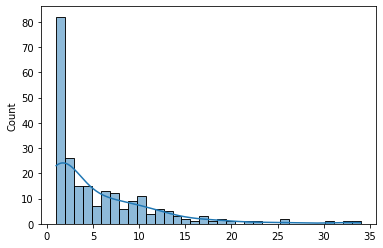

In [310]:
# Visulation of distribution of counts numbers of streets
sns.histplot(street_counts, kde=True,bins =34)

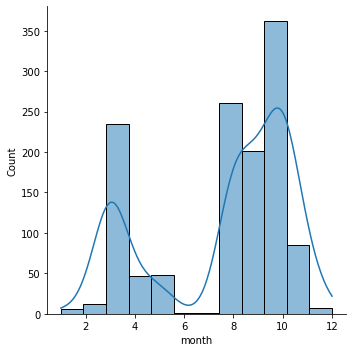

In [270]:
sns.displot(data_chicago['month'],bins =12,kde=True)

In [ ]:
plt.subplot(1,2,1)

In [328]:
data_chicago['day'].value_counts()

Tuesday      444
Thursday     350
Wednesday    338
Monday       128
Friday         5
Sunday         1
Name: day, dtype: int64

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

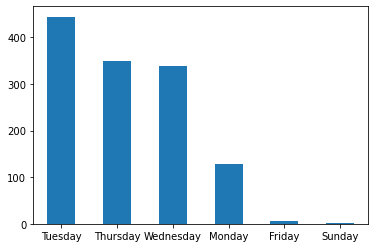

In [324]:

data_chicago['day'].value_counts().plot(kind = 'bar')
plt.xticks(rotation=0)